## Image Captioning using KNN

Although VLMs (Vision Language Models) are the go to tools for image captioning right now, there are interesting works from earlier years that used KNN for captioning and perform surprisingly well enough!

Further, Libraries like [Faiss](https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/) perform the nearest neighbor computation efficiently and are used in many industrial applications.

- In this question you will implement an algorithm to perform captioning using KNN based on the paper [A Distributed Representation Based Query Expansion Approach for
Image Captioning](https://aclanthology.org/P15-2018.pdf)

- Dataset: [MS COCO](https://cocodataset.org/#home) 2014 (val set only)

- Algorithm:
    1. Given: Image embeddings and correspond caption embeddings (5 Per image)
    1. For every image, findout the k nearest images and compute its query vector as the weighted sum of the captions of the nearest images (k*5 captions per image)
    1. The predicted caption would be the caption in the dataset that is closest to the query vector. (for the sake of the assignment use the same coco val set captions as the dataset)

- The image and text embeddings are extracted from the [CLIP](https://openai.com/research/clip) model. (You need not know about this right now)

- Tasks:
    1. Implement the algorithm and compute the bleu score. Use Faiss for nearest neighbor computation. Starter code is provided below.
    1. Try a few options for k. Record your observations.
    1. For a fixed k, try a few options in the Faiss index factory to speed the computation in step 2. Record your observations.
    1. Qualitative study: Visualize five images, their ground truth captions and the predicted caption.
    
Note: Run this notebook on Colab for fastest resu

In [2]:
!pip uninstall --yes gdown

!pip install gdown -U --no-cache-dir
!gdown 1RwhwntZGZ9AX8XtGIDAcQD3ByTcUiOoO #image embeddings

Found existing installation: gdown 4.7.3
Uninstalling gdown-4.7.3:
  Successfully uninstalled gdown-4.7.3
Downloading...
From: https://drive.google.com/uc?id=1RwhwntZGZ9AX8XtGIDAcQD3ByTcUiOoO
To: /content/coco_imgs.npy
100% 83.0M/83.0M [00:00<00:00, 267MB/s]


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!gdown 1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW #caption embeddings

Downloading...
From (original): https://drive.google.com/uc?id=1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW
From (redirected): https://drive.google.com/uc?id=1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW&confirm=t&uuid=0cdfdfc0-6f87-4bc3-8249-743207f962ef
To: /content/coco_captions.npy
100% 415M/415M [00:02<00:00, 164MB/s]


In [5]:
!wget http://images.cocodataset.org/zips/val2014.zip
!unzip /content/val2014.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip /content/annotations_trainval2014.zip
!pip install faiss-cpu

Streaming output truncated to the last 5000 lines.
 extracting: val2014/COCO_val2014_000000376046.jpg  
 extracting: val2014/COCO_val2014_000000066394.jpg  
 extracting: val2014/COCO_val2014_000000277584.jpg  
 extracting: val2014/COCO_val2014_000000383518.jpg  
 extracting: val2014/COCO_val2014_000000262466.jpg  
 extracting: val2014/COCO_val2014_000000153055.jpg  
 extracting: val2014/COCO_val2014_000000155312.jpg  
 extracting: val2014/COCO_val2014_000000010440.jpg  
 extracting: val2014/COCO_val2014_000000541108.jpg  
 extracting: val2014/COCO_val2014_000000202503.jpg  
 extracting: val2014/COCO_val2014_000000161308.jpg  
 extracting: val2014/COCO_val2014_000000153013.jpg  
 extracting: val2014/COCO_val2014_000000089924.jpg  
 extracting: val2014/COCO_val2014_000000289842.jpg  
 extracting: val2014/COCO_val2014_000000191226.jpg  
 extracting: val2014/COCO_val2014_000000157465.jpg  
 extracting: val2014/COCO_val2014_000000218224.jpg  
 extracting: val2014/COCO_val2014_000000030548.j

In [7]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.translate import bleu_score
import faiss
import numpy as np
import matplotlib.pyplot as plt
import random

# New section

In [73]:
def get_transform():
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),  # convert the PIL Image to a tensor
        transforms.Normalize(
            (0.485, 0.456, 0.406),  # normalize image for pre-trained model
            (0.229, 0.224, 0.225),
        )
    ])
    return transform

coco_dset = dset.CocoCaptions(root = '/content/val2014',
                        annFile = '/content/annotations/captions_val2014.json',
                        transform=get_transform())

print(type(coco_dset))

print('Number of samples: ', len(coco_dset))
img, target = coco_dset[3] # load 4th sample

print("Image Size: ", img.shape)
print(target)

loading annotations into memory...
Done (t=0.20s)
creating index...
index created!
<class 'torchvision.datasets.coco.CocoCaptions'>
Number of samples:  40504
Image Size:  torch.Size([3, 224, 224])
['A loft bed with a dresser underneath it.', 'A bed and desk in a small room.', 'Wooden bed on top of a white dresser.', 'A bed sits on top of a dresser and a desk.', 'Bunk bed with a narrow shelf sitting underneath it. ']


In [74]:
ids = list(sorted(coco_dset.coco.imgs.keys()))
print(ids)
captions = []
for i in range(len(ids)):
    captions.append([ele['caption'] for ele in coco_dset.coco.loadAnns(coco_dset.coco.getAnnIds(ids[i]))][:5]) #5 per image
captions_np = np.array(captions)
print('Captions:', captions_np.shape)

[42, 73, 74, 133, 136, 139, 143, 164, 192, 196, 208, 241, 257, 283, 285, 294, 328, 338, 357, 359, 360, 387, 395, 397, 400, 415, 428, 459, 472, 474, 486, 488, 502, 520, 536, 544, 564, 569, 589, 590, 599, 623, 626, 632, 636, 641, 661, 675, 692, 693, 699, 711, 715, 724, 730, 757, 761, 764, 772, 775, 776, 785, 802, 810, 827, 831, 836, 872, 873, 885, 923, 939, 962, 969, 974, 985, 987, 999, 1000, 1029, 1063, 1064, 1083, 1089, 1103, 1138, 1146, 1149, 1153, 1164, 1171, 1176, 1180, 1205, 1228, 1244, 1268, 1270, 1290, 1292, 1296, 1340, 1342, 1347, 1353, 1369, 1374, 1393, 1398, 1404, 1425, 1436, 1442, 1448, 1464, 1490, 1503, 1525, 1532, 1554, 1561, 1563, 1573, 1577, 1584, 1590, 1591, 1592, 1599, 1626, 1647, 1655, 1667, 1668, 1675, 1682, 1700, 1722, 1739, 1757, 1761, 1779, 1799, 1803, 1818, 1840, 1841, 1852, 1856, 1869, 1903, 1948, 1955, 1960, 1987, 1993, 2006, 2014, 2061, 2124, 2139, 2142, 2149, 2153, 2154, 2157, 2164, 2171, 2179, 2191, 2212, 2225, 2235, 2239, 2240, 2255, 2261, 2290, 2295, 2299, 

In [75]:
captions_flat = captions_np.flatten().tolist()
print('Total captions:', len(captions_flat))

Total captions: 202520


In [76]:
cap_path = '/content/coco_captions.npy'
caption_embeddings = np.load(cap_path)
print('Caption embeddings',caption_embeddings.shape)

Caption embeddings (40504, 5, 512)


In [77]:
img_path = '/content/coco_imgs.npy'
image_embeddings = np.load(img_path)
print('Image embeddings',image_embeddings.shape)

Image embeddings (40504, 512)


In [78]:
def accuracy(predict, real):
    '''
    use bleu score as a measurement of accuracy
    :param predict: a list of predicted captions
    :param real: a list of actual descriptions
    :return: bleu accuracy
    '''
    smoother = bleu_score.SmoothingFunction()
    accuracy = 0
    for i, pre in enumerate(predict):
        references = real[i]
        score = bleu_score.sentence_bleu(references, pre, smoothing_function=smoother.method1)
        accuracy += score
    return accuracy/len(predict)

In [79]:
# d = caption_embeddings.shape[2]  # dimension

# index = faiss.IndexFlatL2(d)

# caption_embeddings_flat = caption_embeddings.reshape(-1, d)
# index.add(caption_embeddings_flat)

In [133]:
d = image_embeddings.shape[1]  # dimension

index = faiss.IndexFlatL2(d)

# caption_embeddings_flat = caption_embeddings.reshape(-1, d)
index.add(image_embeddings)
index2 = faiss.IndexFlatL2(d)

caption_embeddings_flat = caption_embeddings.reshape(-1, d)
index2.add(caption_embeddings_flat)

In [81]:
# captions_flat = captions_np.reshape(-1, 1)

# def knn_captioning(k):
#     # print(image_index)
#     _, I = index.search(image_embeddings, k+1)
#     I = I[:, 1:]
#     print(I.shape)
#     caption_index = []
#     query_vectors = []
#     for i in range(I.shape[0]):
#       row = I[i, :]
#       query_vector = np.average(caption_embeddings[row].reshape(k*5, d), axis=0, weights=[i for i in range(k*5, 0,-1)])
#       query_vectors.append(query_vector.reshape(1, -1))

#     query_vectors = np.array(query_vectors).reshape(-1, d)
#     print(query_vectors.shape)
#     _, closest_caption_index = index2.search(query_vectors, 1)

#     true_captions = captions_np.tolist()

#     print(closest_caption_index.shape)
#     print(captions_np[0].shape, type(captions_np[0]))

#     predicted_caption = captions_flat[closest_caption_index].reshape(-1, 1)
#     print(predicted_caption.shape)
#     return true_captions, predicted_caption.tolist()

In [126]:

# class KNNCaptioning():
#   def __init__(self, caption_embeddings, image_embeddings, captions_np):
#     d = caption_embeddings.shape[2]
#     self.index = faiss.IndexFlatL2(d)
#     self.caption_embeddings_flat = caption_embeddings.reshape(-1, d)
#     self.index.add(caption_embeddings_flat)
#     self.image_embeddings = image_embeddings
#     self.captions_np = captions_np
#     self.captions_flat = captions_np.flatten().tolist()

#   def predicted_caption(self, image_index_list, k_list):
#     k_list = sorted(k_list, reverse=True)

#     k_result = {}

#     for i, k in enumerate(k_list):
#       return_array = []
#       for j, image_index in enumerate(image_index_list):
#         _, I = index.search(self.image_embeddings[image_index].reshape(1, -1), k)
#         query_vector = np.mean(self.caption_embeddings_flat[I.flatten()], axis=0)
#         _, closest_caption_index = self.index.search(query_vector.reshape(1, -1), 1)
#         true_captions = self.captions_np[image_index]
#         predicted_caption = self.captions_flat[closest_caption_index[0][0]]
#         return_array.append((predicted_caption, true_captions))
#       k_result[k] = return_array
#     return k_result

#   def accuracy(self, predict, real):
#     '''
#     use bleu score as a measurement of accuracy
#     :param predict: a list of predicted captions
#     :param real: a list of actual descriptions
#     :return: bleu accuracy
#     '''
#     smoother = bleu_score.SmoothingFunction()
#     accuracy = 0
#     for i, pre in enumerate(predict):
#         references = real[i]
#         score = bleu_score.sentence_bleu(references, pre, smoothing_function=smoother.method1)
#         accuracy += score
#     return accuracy/len(predict)

# def knn_captioning(image_index, k):
#     _, I = index.search(image_embeddings[image_index].reshape(1, -1), k)

#     query_vector = np.average(caption_embeddings_flat[I.flatten()], axis=0, weights=[i for i in range(I.shape[1], 0,-1)])

#     _, closest_caption_index = index.search(query_vector.reshape(1, -1), 1)

#     true_captions = captions_np[image_index]

#     predicted_caption = captions_flat[closest_caption_index[0][0]]

#     return true_captions, predicted_caption

def knn_captioning(image_index, k, index, index2):
    _, I = index.search(image_embeddings[image_index].reshape(1, -1), k+1)

    I = I[:, 1:].tolist()
    I_mod = []
    for idx, elem in enumerate(I):
      i = elem[0]
      I_mod.append(i*5)
      I_mod.append(i*5+1)
      I_mod.append(i*5+2)
      I_mod.append(i*5+3)
      I_mod.append(i*5+4)


    wts = []
    for i in range(len(I)):
      wts = [*wts, *[5-i for x in range(5)]]
    I = np.array(I_mod)


    query_vector = np.average(caption_embeddings_flat[I.flatten()], axis=0, weights=wts)

    _, closest_caption_index = index2.search(query_vector.reshape(1, -1), 1)

    true_captions = captions_np[image_index]

    predicted_caption = captions_flat[closest_caption_index[0][0]]

    return true_captions, predicted_caption


Bleu Score (k=1): 0.6135525870380772
Bleu Score (k=2): 0.6198878334543749
Bleu Score (k=3): 0.6070204298187032
Bleu Score (k=4): 0.6176917315356895
Bleu Score (k=5): 0.627469049573447
Bleu Score (k=6): 0.6273419659635258
Bleu Score (k=7): 0.6242459073126316
Bleu Score (k=8): 0.6172397650062701
Bleu Score (k=9): 0.6080971993871107
Bleu Score (k=10): 0.6207960615392104
Time taken using IndexFlatL2: 194.3800985813141 seconds


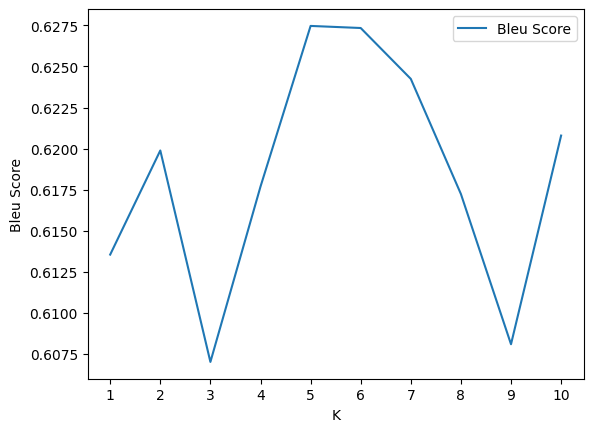

In [134]:
import time
start_time = time.time()

k_values = [i for i in range(1, 11)]

y = []

for k in k_values:
    pred = []
    real = []
    for i in random.sample(range(len(ids)), 500):
        true_captions, predicted_caption = knn_captioning(i, k, index, index2)
        pred.append(predicted_caption)
        real.append(true_captions)
    average_bleu_score = accuracy(pred, real)
    print(f'Bleu Score (k={k}): {average_bleu_score}')
    y.append(average_bleu_score)
print(f"Time taken using IndexFlatL2: {time.time() - start_time} seconds")

plt.plot(k_values, y, label='Bleu Score')
plt.xlabel('K')
plt.ylabel('Bleu Score')
plt.legend()
plt.xticks(k_values, labels=k_values)

plt.show()

Bleu Score (k=1): 0.5320125607334908
Bleu Score (k=2): 0.5326167522283529
Bleu Score (k=3): 0.5351812440488154
Bleu Score (k=4): 0.5360477880582712
Bleu Score (k=5): 0.5400516566645794
Bleu Score (k=6): 0.5461044735582181
Bleu Score (k=7): 0.5415999096573734
Bleu Score (k=8): 0.5437873213946208
Bleu Score (k=9): 0.5413464882384753
Bleu Score (k=10): 0.5446403564962466
Time taken using IVF4096,Flat index: 10.73236894607544 seconds


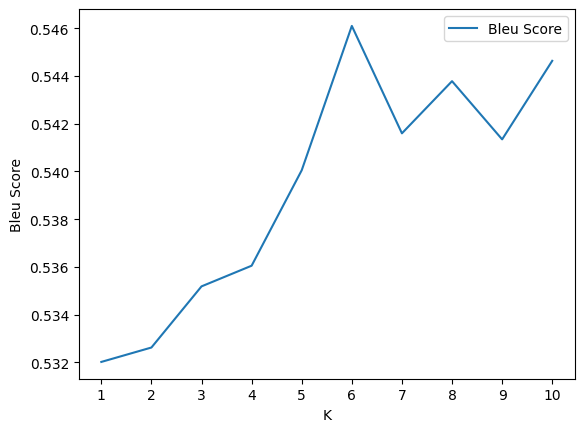

In [130]:
num_embeddings, num_captions, embedding_dim = caption_embeddings.shape

caption_embeddings_flat = caption_embeddings.reshape(-1, embedding_dim)

m = 8
nbits = 8

pq = faiss.IndexPQ(embedding_dim, m, nbits)
pq.train(image_embeddings)
nlist = 100
indexN = faiss.IndexIVFPQ(pq, embedding_dim, nlist, m, nbits, faiss.METRIC_L2)
indexN.train(image_embeddings)
indexN.add_with_ids(image_embeddings, np.arange(num_embeddings))
indexN.nprobe = 10


pq1 = faiss.IndexPQ(embedding_dim, m, nbits)
pq1.train(caption_embeddings_flat)


nlist = 100
indexM = faiss.IndexIVFPQ(pq, embedding_dim, nlist, m, nbits, faiss.METRIC_L2)
indexM.train(caption_embeddings_flat)
indexM.add_with_ids(caption_embeddings_flat, np.arange(num_embeddings * num_captions))

indexM.nprobe = 10


start_time = time.time()

k_values = [i for i in range(1, 11)]

y = []

for k in k_values:
    pred = []
    real = []
    for i in random.sample(range(len(ids)), 500):
        true_captions, predicted_caption = knn_captioning(i, k, indexN, indexM)
        pred.append(predicted_caption)
        real.append(true_captions)
    average_bleu_score = accuracy(pred, real)
    print(f'Bleu Score (k={k}): {average_bleu_score}')
    y.append(average_bleu_score)

print(f"Time taken using IVF4096,Flat index: {time.time() - start_time} seconds")


plt.plot(k_values, y, label='Bleu Score')
plt.xlabel('K')
plt.ylabel('Bleu Score')
plt.legend()
plt.xticks(k_values, labels=k_values)

plt.show()

## Using advance index from fiass factory
It is observed that time has been reduced by a great extent (~20 times faster) compromising BLEU score a little bit.

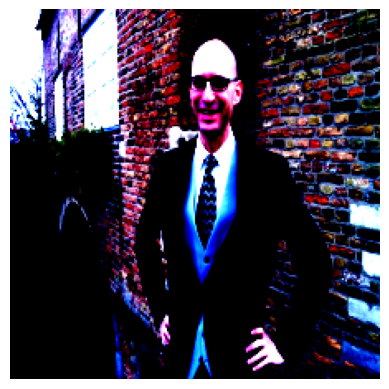

Ground Truth Captions:
- A man wearing a black jacket next to a brick wall.
- a man is smiling in a suit and tie
- Man in suit and tie standing next to bricked building and waterway.
- a male in a black suit jacket and a tie
- A man that is wearing glasses with a tie.
Predicted Caption: A man wearing a suit and a blue tie 



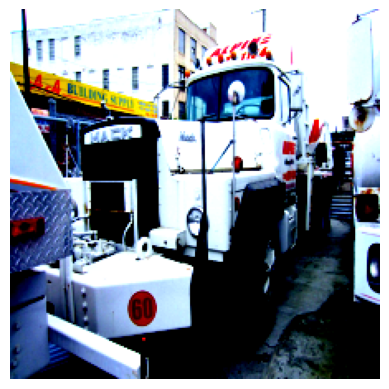

Ground Truth Captions:
- The trucks are all parked closely together. 
- Two large trucks next to each other in a parking lot 
- A large white truck parked beside several buildings.
- A large utility truck butted up against a large white piece of equipment.
- A large white construction truck parked in a lot area in front of a building supply store.
Predicted Caption: The cement truck is parked with the door open. 



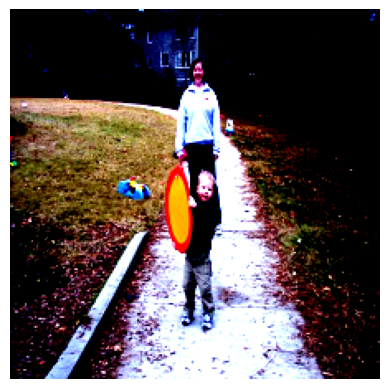

Ground Truth Captions:
- A small child is holding a toy at the park.
- Top-performing very large frisky with mother behind him
- The woman smiles behind a child who's holding a large toy. 
- A woman and small boy playing outside on a path.
- Small child holding an orange and yellow sign in front of a woman. 
Predicted Caption: A boy standing in a field flying a kite.



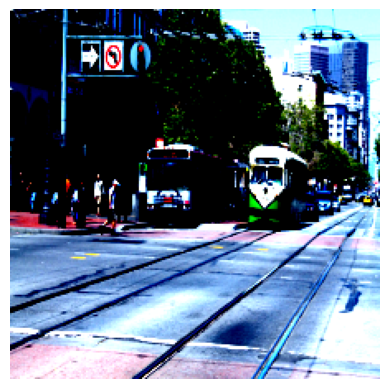

Ground Truth Captions:
- A couple of buses driving down a city street.
- A busy street with two buses driving down.
- A city street with people, a bus, street cars and vehicles.
- A city street with buses and a streetcar and people on a corner.
- A train travelling on a street with buses and cars. 
Predicted Caption: A green car and a bus travel down a street. 



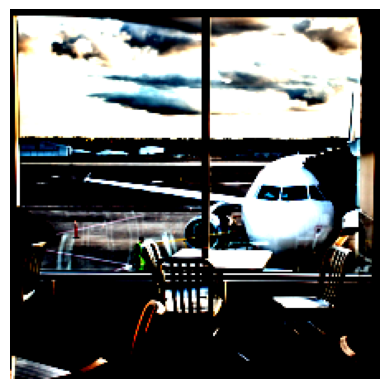

Ground Truth Captions:
- Plane in window with cloudy sky and chairs 
- there is a airplane that is being boarded
- A plane is preparing to load its passengers.
- a large plane is parked outside on the run way
- A picture of an airplane from outside a window.
Predicted Caption: The tarmac has several jets and vehicles at sunset.



In [138]:

sample_indices = random.sample(range(len(ids)), 5)

for i in sample_indices:
    true_captions, predicted_caption = knn_captioning(i, 5, index, index2)

    img, _ = coco_dset[i]
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.axis('off')
    plt.show()

    print("Ground Truth Captions:")
    for caption in true_captions:
        print(f"- {caption}")

    print(f"Predicted Caption: {predicted_caption}\n")


In [85]:
caption_embeddings_flat[np.array([0])].shape

(1, 512)